<a href="https://colab.research.google.com/github/AlinFin/Tumor/blob/main/tumor_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style='background-color:lightblue'>

<div style="text-align:center">
    <h1 style="font-size: 36px; font-weight: bold;">Brain Tumor Classification</h1>
    <h2 style="font-size: 16px;">Alin Finkelshtein and Felix Doctorman</h2>
</div>

In [1]:
import requests

# For Data Processing


import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Miscellaneous
from tqdm import tqdm
import os
import random

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator



In [4]:
!pip install kaggle

In [8]:
#move the uploaded kaglle jason to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:04<00:00, 45.1MB/s]
100% 149M/149M [00:04<00:00, 36.5MB/s]


In [10]:
!unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

## Upload the datasets

In [11]:
# Define the path to the test and train datasets
train_dir = 'Training'
test_dir='Testing'

In [12]:
#Count the number of files in each directory

# Get a list of all files and folders in the directory
files_and_folders = os.listdir(train_dir) # ['glioma', 'meningioma', 'notumor', 'pituitary']
files_and_folders1 = os.listdir(test_dir)


# Count the number of pictures in each folder
train_categories = []
train_counts = []
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    train_categories.append(folder)
    train_counts.append(num_pictures)
    print(f"Number of pictures in train folder {folder}: {num_pictures}")


# Count the number of pictures in each folder for testing dataset
test_categories = []
test_counts = []
for folder in files_and_folders1:
    folder_path = os.path.join(test_dir, folder)
    num_pictures = len(os.listdir(folder_path))
    test_categories.append(folder)
    test_counts.append(num_pictures)
    print(f"Number of pictures in test folder {folder}: {num_pictures}")



Number of pictures in train folder notumor: 1595
Number of pictures in train folder glioma: 1321
Number of pictures in train folder meningioma: 1339
Number of pictures in train folder pituitary: 1457
Number of pictures in test folder notumor: 405
Number of pictures in test folder glioma: 300
Number of pictures in test folder meningioma: 306
Number of pictures in test folder pituitary: 300


In [13]:
files_and_folders

['notumor', 'glioma', 'meningioma', 'pituitary']

## Create pies to see the categories division in train and test datasets

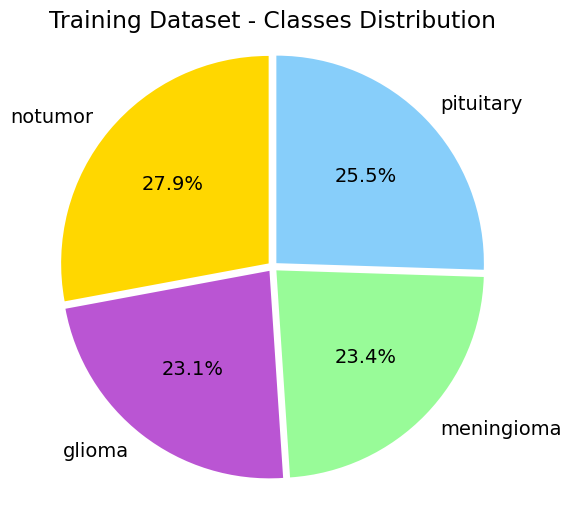

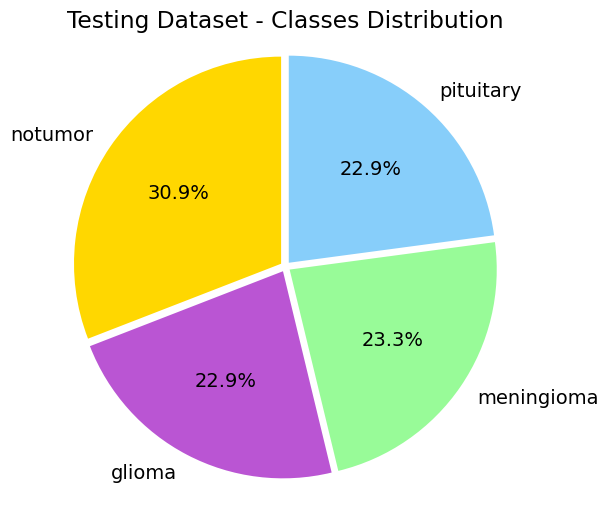

In [14]:

# Define custom colors for the pie chart

colors = ['gold', 'mediumorchid', 'palegreen', 'lightskyblue']

# Create a pie chart for the training dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(train_counts, labels=train_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Training Dataset - Classes Distribution')
plt.axis('equal')
plt.show()

# Create a pie chart for the testing dataset
plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':14})
plt.pie(test_counts, labels=test_categories,colors=colors, autopct='%1.1f%%', explode=(0.025,0.025, 0.025,0.025),startangle=90)
plt.title('Testing Dataset - Classes Distribution')
plt.axis('equal')
plt.show()


## The data is balanced.

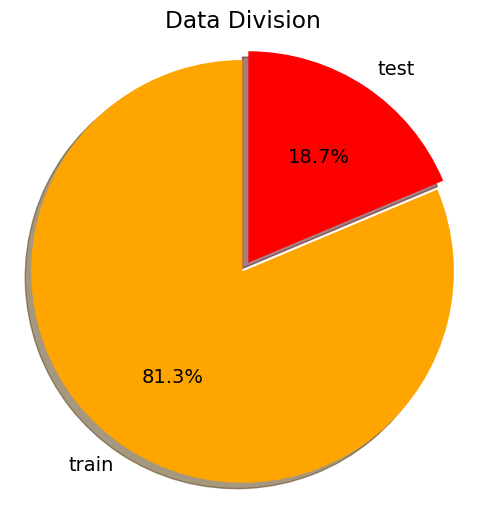

In [15]:
# That is the proportion of train and test

# The total number of pictures in train and test
train_size=sum(train_counts)
test_size= sum(test_counts)

colors = ['orange', 'red']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 14})
plt.pie([train_size, test_size], labels=['train', 'test'], colors=colors, autopct='%1.1f%%', explode=(0.05, 0),
        startangle=90, shadow=True)
plt.title('Data Division')
plt.axis('equal')
plt.show()


In [16]:
print(train_size, test_size)

5712 1311


## Lets see some samples of the classes

In [18]:
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    print(folder_path)

Training/notumor
Training/glioma
Training/meningioma
Training/pituitary


## Normal brain

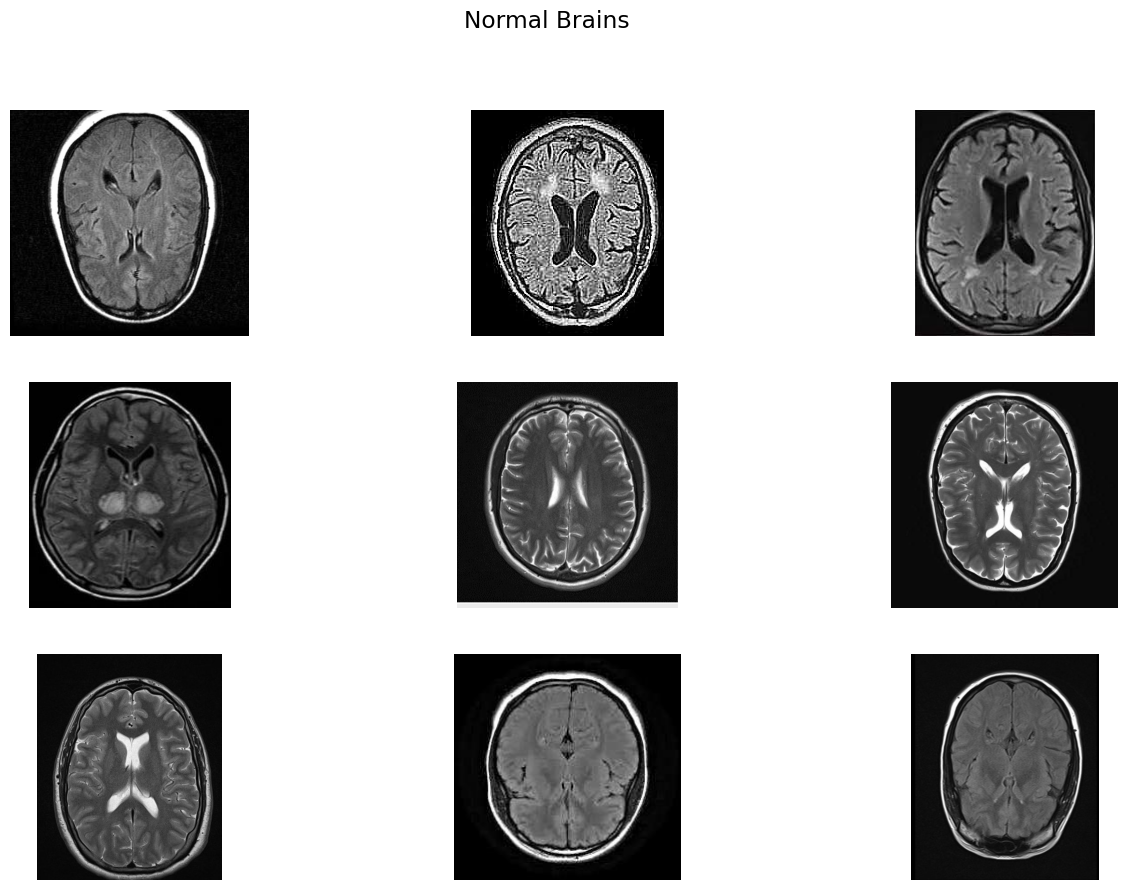

In [19]:


notumor_dir = 'Training/notumor'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(notumor_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 9)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Normal Brains')

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(os.path.join(notumor_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


## Glioma Tumor

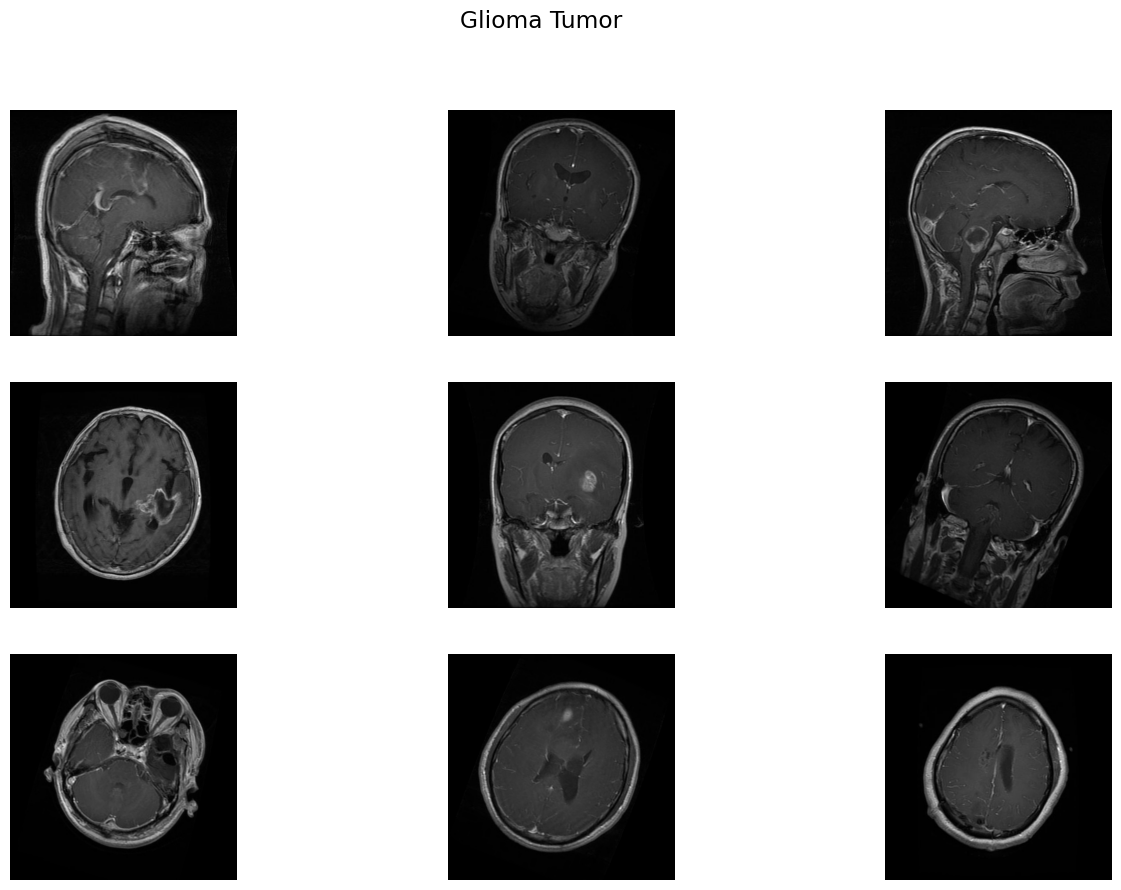

In [44]:
glioma_dir = 'Training/glioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(glioma_dir)

# Randomly select 9 images
selected_images = random.sample(image_files, 9)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Glioma Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(os.path.join(glioma_dir, filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


In [45]:
## Meningioma Tumor

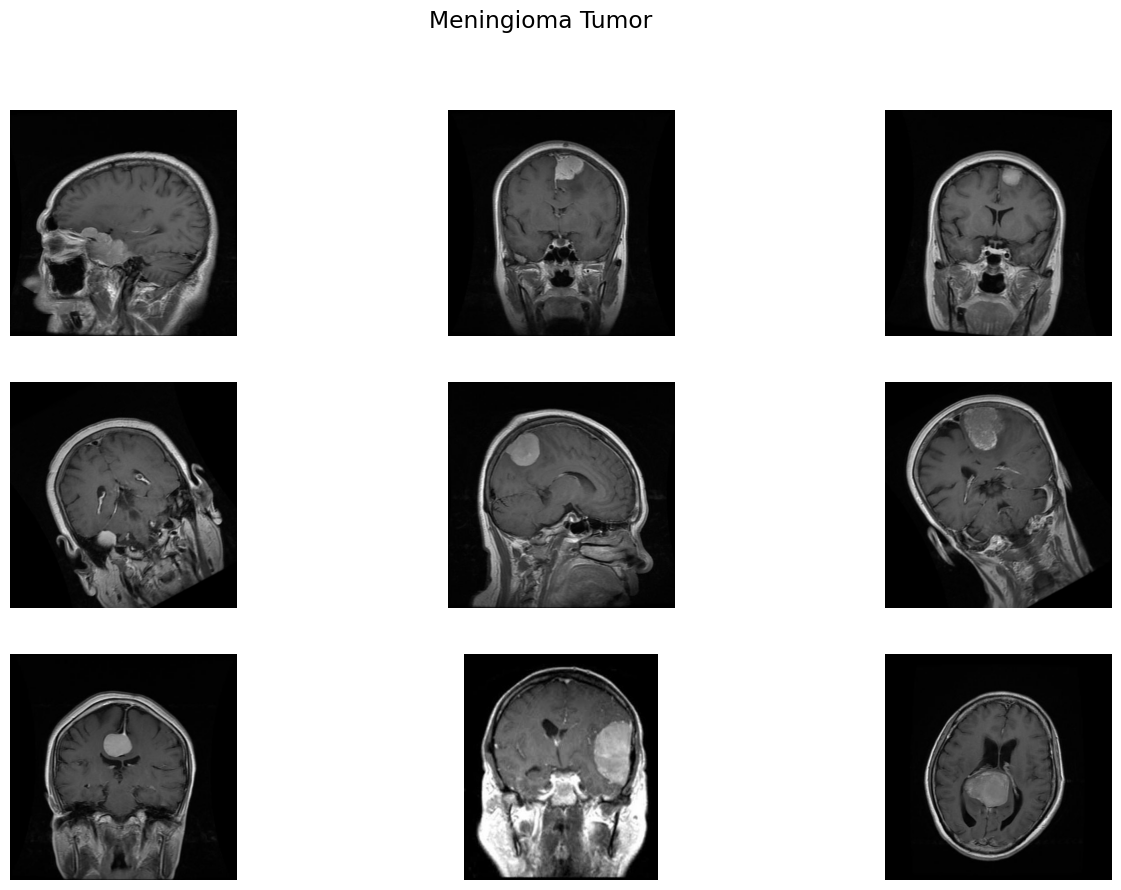

In [46]:

meningioma_dir = 'Training/meningioma'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(meningioma_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 9)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Meningioma Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(os.path.join(meningioma_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


## Pituitary Tumor

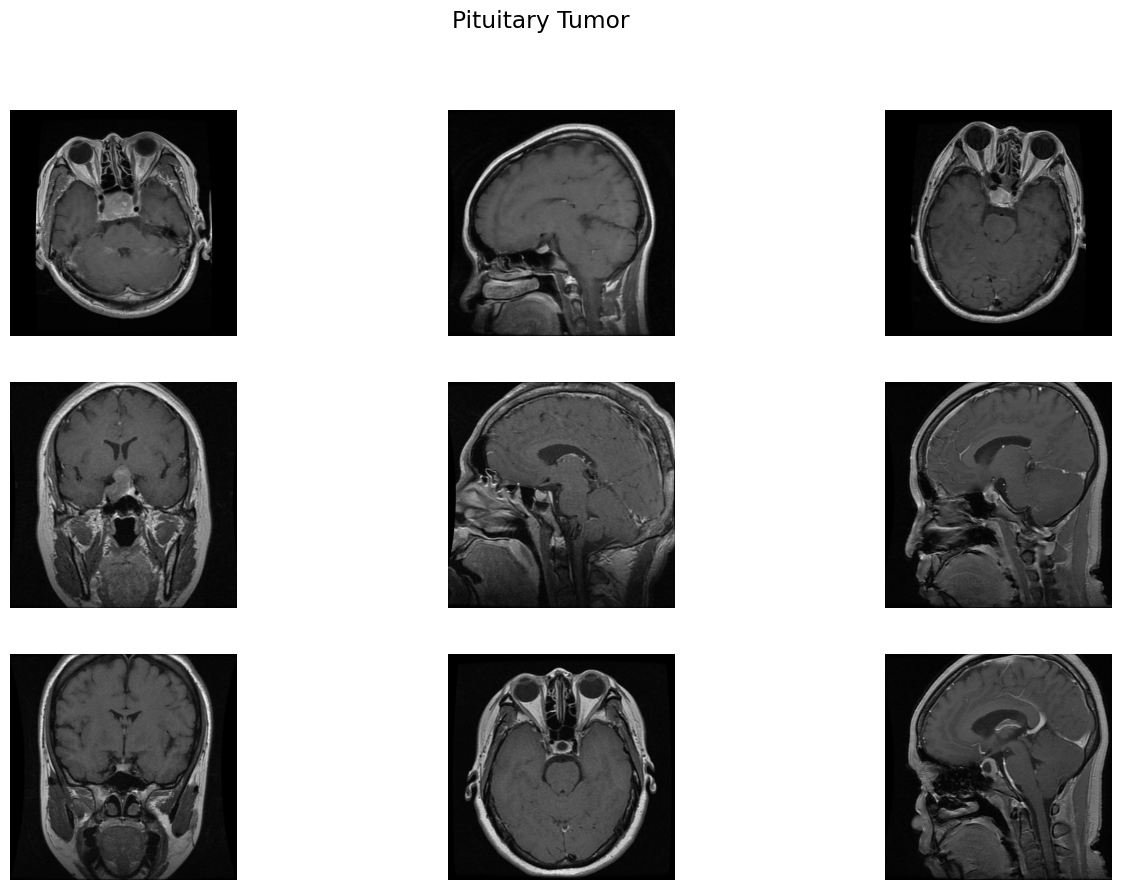

In [23]:
pituitary_dir = 'Training/pituitary'

# Get a list of all image files in the "notumor" category
image_files = os.listdir(pituitary_dir )

# Randomly select 9 images
selected_images = random.sample(image_files, 9)

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Pituitary Tumor')

x=10

for i, filename in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(os.path.join(pituitary_dir , filename))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

plt.show()


##  Data Augmentation

Performing data augmentation  can involve various transformations creating new similar images. Data augmentation is a technique used to increase the diversity and size of your dataset by applying these transformations to existing images. Augmentation can  effectively expanding your dataset and improving the generalization capabilities of your model.

In this case Rotation and flipping will be the most apropriate transformations.

In [52]:
augmented_train_files = []  # List to store the file paths of the augmented images

# Define the augmentation parameters
rotation_range = (-30, 30)  # Specify the range of rotation angle in degrees
flip_horizontal = True  # Specify whether to flip horizontally

# Get the list of image files in the training directory
folders = os.listdir(train_dir) #['glioma', 'meningioma', 'notumor', 'pituitary']

# Iterate over the folders
for folder in files_and_folders:
    folder_path = os.path.join(train_dir, folder)
    image_files = os.listdir(folder_path) # Get the list of image files in the current folder

    for filename in image_files: # Iterate over the image files and apply augmentation
        image_path = os.path.join(folder_path, filename) # Load the image
        image = cv2.imread(image_path)

        angle = random.uniform(rotation_range[0], rotation_range[1]) # Generate a random rotation angle within the specified range
        rotation_matrix = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1) # Apply rotation augmentation
        rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))

        if flip_horizontal: # Apply flipping augmentation
            flipped_image = cv2.flip(rotated_image, 1)  # Flip horizontally
        else:
            flipped_image = rotated_image

        augmented_filename = 'augmented_' + filename # Save the augmented image
        augmented_image_path = os.path.join(folder_path, augmented_filename)
        cv2.imwrite(augmented_image_path, flipped_image)
        augmented_train_files.append(augmented_image_path)  # Add the augmented image to the list


In [53]:
# How many images we have after augmentation?

len(augmented_train_files)

17136

In [54]:
augmented_train_files

['Training/notumor/augmented_augmented_augmented_Tr-no_0812.jpg',
 'Training/notumor/augmented_Tr-no_0988.jpg',
 'Training/notumor/augmented_Tr-no_1199.jpg',
 'Training/notumor/augmented_augmented_Tr-no_1099.jpg',
 'Training/notumor/augmented_augmented_Tr-no_1524.jpg',
 'Training/notumor/augmented_augmented_Tr-no_1033.jpg',
 'Training/notumor/augmented_augmented_augmented_Tr-no_0707.jpg',
 'Training/notumor/augmented_Tr-no_1129.jpg',
 'Training/notumor/augmented_Tr-no_1006.jpg',
 'Training/notumor/augmented_Tr-no_1093.jpg',
 'Training/notumor/augmented_augmented_augmented_Tr-no_0370.jpg',
 'Training/notumor/augmented_augmented_Tr-no_0015.jpg',
 'Training/notumor/augmented_augmented_Tr-no_1324.jpg',
 'Training/notumor/augmented_augmented_Tr-no_0976.jpg',
 'Training/notumor/augmented_augmented_augmented_Tr-no_0763.jpg',
 'Training/notumor/augmented_augmented_augmented_Tr-no_0944.jpg',
 'Training/notumor/augmented_Tr-no_0363.jpg',
 'Training/notumor/augmented_augmented_Tr-no_1421.jpg',
 '

In [55]:
# In the list I can only see glioma, does other classes present as well?
folders_to_check = ['notumor', 'meningioma', 'pituitary']

# Check if the folders are present in the paths
for folder in folders_to_check:
    is_present = any(folder in path for path in augmented_train_files)
    if is_present:
        print(f"The folder {folder} is present in the augmented train files.")
    else:
        print(f"The folder {folder} is not present in the augmented train files.")

The folder notumor is present in the augmented train files.
The folder meningioma is present in the augmented train files.
The folder pituitary is present in the augmented train files.


In [56]:
categories=['glioma', 'meningioma', 'notumor', 'pituitary']

# List to store tuples of (image path, category index)
image_data = []

# Iterate over the image paths in augmented_train_files
for path in augmented_train_files:
    category = path.split('Training/')[-1].split('/')[0] # Extract the category from the image path
    category_index = categories.index(category) # Find the index of the category in the categories list
    image_data.append((path, category_index)) # Append the tuple (image path, category index) to image_data


In [57]:
image_data[1:10]

[('Training/notumor/augmented_Tr-no_0988.jpg', 2),
 ('Training/notumor/augmented_Tr-no_1199.jpg', 2),
 ('Training/notumor/augmented_augmented_Tr-no_1099.jpg', 2),
 ('Training/notumor/augmented_augmented_Tr-no_1524.jpg', 2),
 ('Training/notumor/augmented_augmented_Tr-no_1033.jpg', 2),
 ('Training/notumor/augmented_augmented_augmented_Tr-no_0707.jpg', 2),
 ('Training/notumor/augmented_Tr-no_1129.jpg', 2),
 ('Training/notumor/augmented_Tr-no_1006.jpg', 2),
 ('Training/notumor/augmented_Tr-no_1093.jpg', 2)]

####  All the train data images files are located in augmented_train_files as a list of pathes

In [58]:
len(image_data)

17136

## Mix the data randomly

In [59]:

# Shuffle the data randomly
random.shuffle(image_data)

image_data[1:10]

[('Training/glioma/augmented_Tr-gl_0366.jpg', 0),
 ('Training/pituitary/augmented_augmented_augmented_Tr-pi_1002.jpg', 3),
 ('Training/meningioma/augmented_Tr-me_0505.jpg', 1),
 ('Training/glioma/augmented_augmented_augmented_Tr-gl_0287.jpg', 0),
 ('Training/meningioma/augmented_augmented_Tr-me_1172.jpg', 1),
 ('Training/pituitary/augmented_augmented_augmented_Tr-pi_1144.jpg', 3),
 ('Training/pituitary/augmented_augmented_Tr-pi_0156.jpg', 3),
 ('Training/glioma/augmented_augmented_Tr-gl_1100.jpg', 0),
 ('Training/meningioma/augmented_augmented_Tr-me_0556.jpg', 1)]

## Images after augmentation


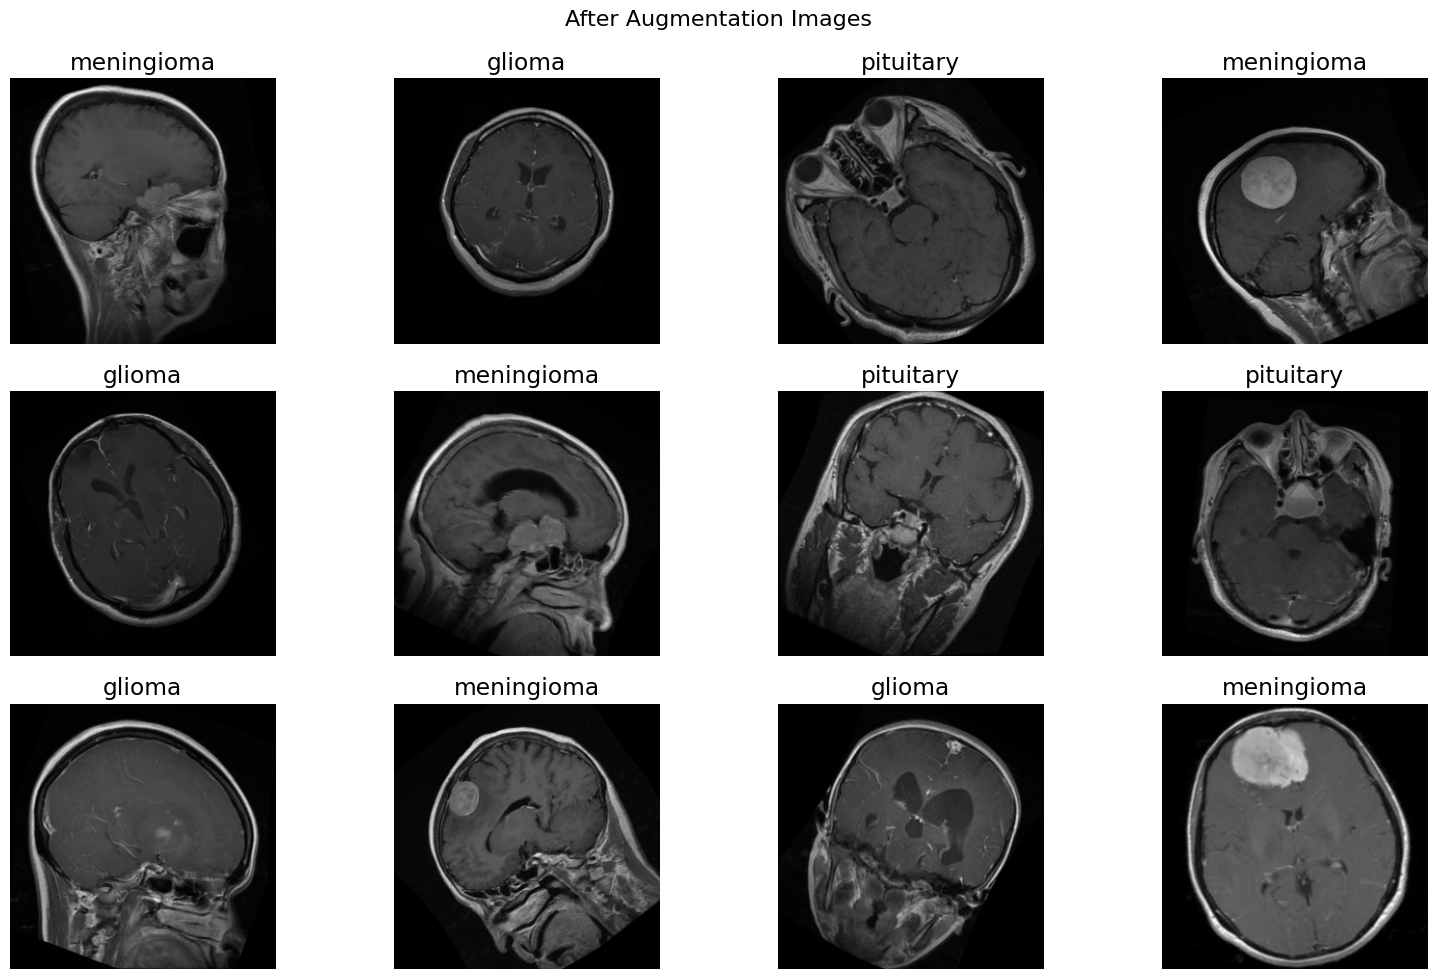

In [60]:
# Create a function to show images with titles
def show_images_with_titles(image_data, categories, num_images=12):
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    fig.suptitle('After Augmentation Images', fontsize=16)

    for i, (image_path, category_index) in enumerate(image_data[:num_images]):
        # Read and resize the image
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (256, 256))

        # Get the category name from the categories list using the category_index
        category_name = categories[category_index]

        # Plot the image and set the title to the category name
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img_resized)
        axes[row, col].set_title(category_name)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to show the images with titles
show_images_with_titles(image_data, categories, num_images=12)

# Preprocessing
### For CNN we need an input with 4 dimentions.
### Convert the images to np.array

In [61]:
#inspect image shape
# Load one image from image_data
sample_image_path, _ = image_data[0]  # image_data is a list of tuples (image_path, category_index)
sample_image = cv2.imread(sample_image_path)

# Print the shape of the sample image
print("Shape of the sample image:", sample_image.shape)

Shape of the sample image: (512, 512, 3)


In [62]:
# Reduce dimensions and reshape the image
images = []

# Iterate over the image paths in image_data
for path, _ in image_data:
    img = cv2.imread(path)   # Load the image
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert from RGB to gray
    gray_img = cv2.resize(gray_img, (128, 128)) # Resize the image to (128,128)
    gray_img = np.expand_dims(gray_img, axis=-1)  # Add the extra dimension for the color channel
    img = np.array(gray_img)  # Convert the image to a numpy array

    images.append(img) # Add the image to the list of images

# Convert the list of individual image arrays into a 4-dimensional numpy array
image_array = np.array(images)

# Check the shape of the resulting array
print(image_array.shape)

(17136, 128, 128, 1)


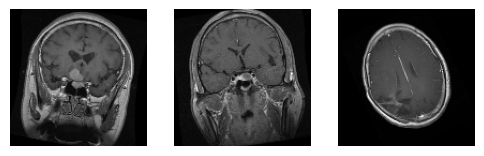

In [63]:
#see image example after reshaping
# Choose the indices of the images you want to visualize
example_indices = [15, 1789, 3765]

# Create a 1x3 subplot grid
plt.figure(figsize=(6, 2))
for i, example_index in enumerate(example_indices):
    plt.subplot(1, 3, i + 1)

    # Get the image at the chosen index from the image_array
    example_image = image_array[example_index]

    # Plot the image using Matplotlib
    plt.imshow(example_image.squeeze(), cmap='gray')
    plt.axis('off')

plt.show()

In [64]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    image_array,  # Image data with shape (17136, 128, 128, 1)
    [label for _, label in image_data],  # Extract the category indexes from the image_data list
    test_size=0.2,
    random_state=42
)

# Check the shapes of the resulting arrays
print(X_train.shape)
print(X_val.shape)
print(np.array(y_train).shape)
print(np.array(y_val).shape)



(13708, 128, 128, 1)
(3428, 128, 128, 1)
(13708,)
(3428,)


In [65]:
#Convert the categories to One_hot_encoder
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

# CNN model

In [73]:
model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 50

es = EarlyStopping(
    monitor='loss',
    mode='max',
    patience = 10
)

batch_size = 20
imggen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

# Fit the model with Train and Validation datatsets

In [77]:
imggen.fit(X_train)
history = model.fit(imggen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks = [es])

Epoch 1/50
685/685 [==============================] - 21s 30ms/step - loss: 0.2824 - accuracy: 0.8947 - val_loss: 0.3604 - val_accuracy: 0.8687
Epoch 2/50
685/685 [==============================] - 21s 30ms/step - loss: 0.2698 - accuracy: 0.8990 - val_loss: 0.4089 - val_accuracy: 0.8454
Epoch 3/50
685/685 [==============================] - 20s 29ms/step - loss: 0.2604 - accuracy: 0.9051 - val_loss: 0.2843 - val_accuracy: 0.8801
Epoch 4/50
685/685 [==============================] - 20s 30ms/step - loss: 0.2541 - accuracy: 0.9077 - val_loss: 0.6716 - val_accuracy: 0.7628
Epoch 5/50
685/685 [==============================] - 20s 30ms/step - loss: 0.2645 - accuracy: 0.9050 - val_loss: 0.2334 - val_accuracy: 0.9134
Epoch 6/50
685/685 [==============================] - 21s 31ms/step - loss: 0.2422 - accuracy: 0.9132 - val_loss: 0.2670 - val_accuracy: 0.8938
Epoch 7/50
685/685 [==============================] - 20s 29ms/step - loss: 0.2698 - accuracy: 0.9043 - val_loss: 0.2610 - val_accuracy:

In [75]:
# Get the loss and accuracy of the last epoch
last_epoch_loss = history.history['loss'][-1]
last_epoch_accuracy = history.history['accuracy'][-1]

# Print the results
print(f"Last Epoch - Loss: {last_epoch_loss:.4f}, Accuracy: {last_epoch_accuracy:.4f}")

Last Epoch - Loss: 0.2752, Accuracy: 0.8969


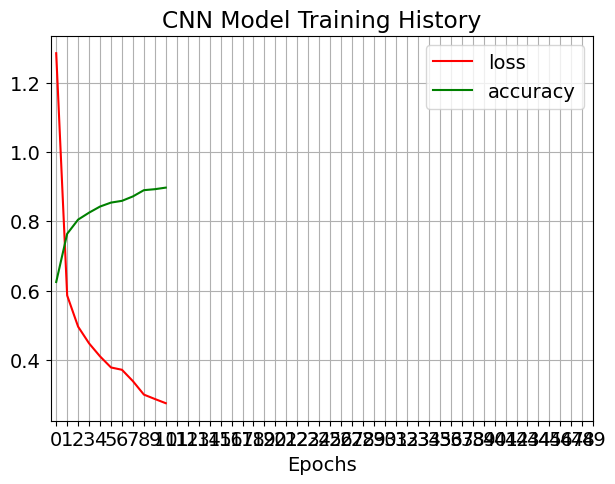

In [76]:
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["accuracy"],c = "green")
plt.grid(True)
plt.title("CNN Model Training History")
#plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(["loss", "accuracy"])
plt.rcParams["figure.figsize"] = (7,5)
plt.show()